## DAS Data Analysis
- Notebook used for analyzing my raw DAS data
- Specifically for mapping out fiber with vehicle GNSS data
- Updated to have only relevant sections of Original File
- Added sections necessary for SJC Mapping

### Notebook-related

In [1]:
%load_ext autoreload
%autoreload 2

## Import packages

In [2]:
# !pip install numpy

In [3]:
import numpy as np
import scipy.signal as signal
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta, timezone
import matplotlib.dates as mdates
import socket
from pathlib import Path
import dascore as dc
import pwlf
from statsmodels.nonparametric.smoothers_lowess import lowess
import folium
import os

from utils import (
    file2load, preproc_data,
    process_file, # noqa
    loadconcat_par,
    calc_PSD, trapz_PSD,
    das_waterfall,
    space_conv_das_gl,
    _format_time_axis_mine, # TODO refine this function if needed
    dms_to_decimal, read_nmea2,
    calculate_bearing, signed_geodesic_perpendicular_distance,
)

from add_utils import *

# Identify hostname
hostname = socket.gethostname()
print("Hostname:", hostname)

# Enable interactive mode
%matplotlib widget


Hostname: VS-ultimate-all-in-one-Book


## Analysis options

#### Core options
- Timezone info. (for plotting)
- Channel range
- Preprocessing options
- Convert to physical strain from DAS data (Not Done in this notebook)
- Data information (sampling frequency)

#### Channel Settings

In [4]:
# Set analysis options
analysis_opt = {}
pdt_tz = timezone(timedelta(hours=-7))
# analysis_opt["local_tz"] = timezone(timedelta(hours=-7)) # PDT

# relevant variables in one place

### changed this on 06-16-2025
analysis_opt["target_structure"] = "subloop"
# analysis_opt["target_structure"] = "b2b3"

match analysis_opt["target_structure"]:
    
### Added this on 06-16-2025
    case "subloop":
        # Subloop defined in the excel file of the SJC expt
        analysis_opt["fbeg"] = 0  #found later
        analysis_opt["fend"] = 0  #found later

# Set channel range for loading via memmap

# Set channel range for loading files via memmap array,
# in actual channel numbers/convention
analysis_opt["mmap_chan"] = np.arange(analysis_opt["fbeg"], analysis_opt["fend"])

#### Time settings

In [5]:
# Beginning and end time of the analysis, for loading files
# Testing the Subloop
analysis_opt["beg_time"] = datetime(2023, 9, 20, 10, 50, 00, tzinfo=timezone.utc)
analysis_opt["end_time"] = datetime(2023, 9, 20, 10, 55, 00, 00, tzinfo=timezone.utc)
####analysis_opt["end_time"] = datetime(2023, 9, 20, 11, 05, 00, 00, tzinfo=timezone.utc)
# analysis_opt["beg_time"] = datetime(2023, 9, 22, 10, 6, 32, tzinfo=pdt_tz)
# analysis_opt["end_time"] = datetime(2023, 9, 22, 10, 8, 52, tzinfo=pdt_tz)



#### Other Important Analysis Options (ft. Filters and Detrend)

In [6]:
# Bandpass/lowpass/highpass filter options
# commonly used cutoffs:
# 0.01, 0.1 (for quasi-static)
# from inspection of b1 data, 0.0001 cutoff ideally gets rid of "thermal" induced periodic change in DAS bridge strain?
# 0.001 is sufficient for removing temperature effects, I think.
# 1.0 (dynamic), 2.0 (all sjc bridges), 2.0 (b2), 2.5 (b1), 4.0 (b3),

# analysis_opt["detrend"] = None
analysis_opt["detrend"] = "constant"
# analysis_opt["detrend"] = "linear"

# analysis_opt["bp_hz"] = None # no bandpass
# analysis_opt["bp_hz"] = [0.001, 2.0] # quasi-static
# analysis_opt["bp_hz"] = [0.01, 1.0] # quasi-static
analysis_opt["bp_hz"] = [0.1, 1.0] # quasi-static, 0.1
# analysis_opt["bp_hz"] = [0.1, 2.0] # expanded quasi-static
# analysis_opt["bp_hz"] = [3.0, 20.0] # surface waves
# analysis_opt["bp_hz"] = [1.0, 50.0] # dynamic responses

analysis_opt["hp_hz"] = None

# Decimation
analysis_opt["deci_q"] = 1
# analysis_opt["deci_q"] = 10 # decimate if needed due to memory constraints

analysis_opt["das2eps"] = True # convert DAS signal to strain, according to attrs
# analysis_opt["allchandt"] = False # detrend the all-channel trends taken with the median
analysis_opt["allchandt"] = True # detrend the all-channel trends taken with the median

analysis_opt["fs"] = 200
analysis_opt["dt"] = 1/analysis_opt["fs"]

analysis_opt["synGL"] = None

#### Miscealleanous options
- Time slice exactly according to beg and end time in analysis_opt
- Timezone convention of the filenames
- Filename prefix

In [7]:
# analysis_opt["file_time_slice"] = False #
analysis_opt["file_time_slice"] = True # TODO more robust method? Drift?

# The length of each save file in hours
analysis_opt["fetched_file_timed_hr"] = timedelta(hours=1)


In [8]:
# figure plot options
# e.g.,
# do_plot_allchan_trends = True
do_plot_allchan_trends = False
do_plot_post_preproc_time_series = False
do_das_ts_compare = False
do_band_based_PSD_energy = False
do_plot_multipsd = False

## Getting the channels for DAS data plotting

- Importing the Tap Test File - tap_test_df
- Plotting the tap test data 
- Importing the Vehicle GPS Dataset - vehicle_df
- Plotting the Vehicle GPS data - Get the timestamps (analysis_opt["beg_time"] and analysis_opt["end_time"]) of the req stretch- cross check the Subloop Mapping Points
- Finding the vehicle GPS at the analysis_opt["beg_time"] and analysis_opt["end_time"] vehicle_bounds_df
- Finding the Tap Tests closest to these vehicle GPS locations- matched_taps_df
- Finding the tap test channels to the time at which the vehicle crosses the tap test point- vehicle_tap_crossings list having dictionary with keys "CH" and "Time" 

- The time to cross the tap test channel comes from-
    - Get the GPS of the closest tap test channels
    - Get the closest vehicle gps point to the tap test gps points
    - Get the time of these closest gps points


- Map the channels to the times, independent of tap tests


#### Loading the Tap Tests GPS 


In [9]:
#Loading the tap test excel file
local_folder = "C:/Users/varun/OneDrive - Stanford/Desktop/Stanford/3. Spring 25 Quarter/Independent Research- Geolocalization of Telecom Cables"
# local_folder = "C:/Users/varun/OneDrive - Stanford/DAS/2023-09-20"
tap_test_excel_path = f"{local_folder}/Tap-test-CCW.xlsx"
tap_test_df = pd.read_excel(tap_test_excel_path)
tap_test_df.columns

Index(['Unnamed: 0', 'Location', 'Lat', 'Long', 'Localized Channels',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'],
      dtype='object')

In [10]:
### Plotting all the GPS coordinates from the Tap Test data
# Convert Long column to float (it's currently string)
tap_test_df['Long'] = pd.to_numeric(tap_test_df['Long'], errors='coerce')

# Drop rows with invalid Lat or Long
tap_test_df = tap_test_df.dropna(subset=['Lat', 'Long'])

# Plot full dataset using function in add_utils.py
plot_tap_test_map(
    df=tap_test_df,
    lat_col='Lat',
    lon_col='Long',
    label_col='Localized Channels',
    map_filename='tap_test_full_map.jpg',
    zoom_start=12
)



Map saved to tap_test_full_map.jpg


In [11]:
# Cleaning the Localized Channels to give single mean channel number in Channel Column
#in add_utils.py
tap_test_df = parse_channel_column(tap_test_df)
tap_test_df.head()

Unnamed: 0          Location        Lat        Long Localized Channels  \
0           1       Outside 1.1  37.336971 -121.886781            238-270   
1           2  3rd/San Fernando  37.335225 -121.886894            661-678   
2           3    3rd/San Carlos  37.332501 -121.884801                NaN   
3           4       3rd/William  37.329457 -121.882856                NaN   
4           5          1st/Reed  37.327266 -121.883827                NaN   

   Unnamed: 5  Unnamed: 6  Unnamed: 7 Unnamed: 8  Channel  
0         NaN         NaN         NaN        NaN    254.0  
1         NaN         NaN         NaN        NaN    669.0  
2         NaN         NaN         NaN        NaN      NaN  
3         NaN         NaN         NaN        NaN      NaN  
4         NaN         NaN         NaN        NaN      NaN

#### Loading the binary files for Vehicle GPS Data

In [12]:
 
# folder_path = "G:\\Shared drives\\SJC Experiment\\VSS\\1002_mapping"
# file = "COM8_20231002_025202.csv"  
# folder_path = "G:\\Shared drives\\SJC Experiment\\VSS\\920_mapping\\gps"
# file = "COM6_20230920_041722.csv"
folder_path = "G:\\Shared drives\\SJC Experiment\\VSS\\927_mapping"
file = "COM3_20230927_035002.csv"  
# folder_path = "G:\\Shared drives\\SJC Experiment\\VSS\\922_mapping\\gps"
# file = "COM6_20230922_031946.csv"
file_path = os.path.join(folder_path, file)

# Function to load vehicle GPS data and convert timestamps to UTC 
# in add_utils.py
vehicle_df = load_vehicle_gps(file_path)
vehicle_df.head()

datetime_utc        Lat        Long
0 2023-09-27 10:50:04.000040891  37.278224 -121.834619
1 2023-09-27 10:50:04.199969394  37.278225 -121.834619
2 2023-09-27 10:50:04.399988426  37.278225 -121.834619
3 2023-09-27 10:50:04.600007459  37.278225 -121.834619
4 2023-09-27 10:50:04.800016435  37.278225 -121.834619

In [13]:
#Plotting the vehicle GPS data on a map using folium
# in add_utils.py

#filter_point_interval is the interval at which points are plotted on the map
# e.g., filter_point_interval = 100 will plot every 100th point
filter_point_interval = 20
vehicle_map= plot_vehicle_gps_folium(vehicle_df,filter_point_interval)
vehicle_map.save("maps/vehicle_gps_map_9_27_COM3_20230927_035002.html") 
vehicle_map

In [14]:
beg_time = analysis_opt["beg_time"]
end_time = analysis_opt["end_time"]
# Ensure 'datetime_utc' is in datetime format
vehicle_df['datetime_utc'] = pd.to_datetime(vehicle_df['datetime_utc'])

# Handle timezone conversion
if vehicle_df['datetime_utc'].dt.tz is None:
    # Naive timestamps: localize to UTC
    vehicle_df['datetime_utc'] = vehicle_df['datetime_utc'].dt.tz_localize('UTC')
else:
    # Already timezone-aware: convert to UTC
    vehicle_df['datetime_utc'] = vehicle_df['datetime_utc'].dt.tz_convert('UTC')


# Get the vehicle GPS point closest to the specified time bounds 
# start and end times corresponding to the analysis_opt["beg_time"] and analysis_opt["end_time"]
# in add_utils.py
vehicle_bounds_df = get_vehicle_gps_at_time_bounds(vehicle_df, beg_time, end_time)
vehicle_bounds_df.head()

datetime_utc        Lat        Long
0 2023-09-27 10:50:04.000040891+00:00  37.278224 -121.834619
0 2023-09-27 10:50:04.000040891+00:00  37.278224 -121.834619

In [15]:
# Match vehicle GPS points in vehicle_bounds_df to the closest tap test points by gps distance
# in add_utils.py
matched_taps_df = match_vehicle_points_to_closest_taps(vehicle_bounds_df, tap_test_df)
matched_taps_df.head()

Vehicle Lat  Vehicle Long                  Vehicle Time (UTC)    Tap Lat  \
0    37.278224   -121.834619 2023-09-27 10:50:04.000040891+00:00  37.277983   
1    37.278224   -121.834619 2023-09-27 10:50:04.000040891+00:00  37.277983   

    Tap Long     Tap Location  Channel  Distance (m)  
0 -121.83472  Monterey/Senter  23090.0     28.234015  
1 -121.83472  Monterey/Senter  23090.0     28.234015

In [16]:
cleaned_tap_df = tap_test_df[["Channel"]].copy()
cleaned_tap_df["Tap Lat"] = tap_test_df["Lat"].values
cleaned_tap_df["Tap Long"] = tap_test_df["Long"].values
# Drop rows with NaN channels and reset index
cleaned_tap_df = cleaned_tap_df.dropna(subset=["Channel"]).reset_index(drop=True)
# convert channel to integer
cleaned_tap_df["Channel"] = cleaned_tap_df["Channel"].astype(int)
cleaned_tap_df.shape
cleaned_tap_df
# vehicle_tap_crossings_all = find_closest_vehicle_to_each_tap(vehicle_df, tap)

Channel    Tap Lat    Tap Long
0       254  37.336971 -121.886781
1       669  37.335225 -121.886894
2      2427  37.322853 -121.880305
3      3450  37.316618 -121.873907
4      4820  37.308410 -121.865710
5      5410  37.304730 -121.862090
6      6156  37.300715 -121.858549
7      7976  37.290234 -121.848227
8      8465  37.287283 -121.845185
9      9120  37.284389 -121.842016
10    10140  37.278123 -121.835665
11    10672  37.274697 -121.832143
12    11240  37.272125 -121.828954
13    12202  37.266715 -121.821216
14    13824  37.260252 -121.810534
15    14752  37.256264 -121.803746
16    15505  37.253296 -121.803825
17    17405  37.251631 -121.817754
18    18242  37.251630 -121.825183
19    18740  37.251475 -121.830621
20    19242  37.254654 -121.831019
21    19890  37.258924 -121.830669
22    20825  37.266608 -121.830932
23    22167  37.272786 -121.829079
24    23090  37.277983 -121.834720
25    24640  37.282167 -121.823580
26    25566  37.287900 -121.827819
27    26192  37.288130 -121.821708
28    27157  37.292391 -121.813566
29    28757  37.299938 -121.802627
30    30760  37.296397 -121.784908
31    31705  37.297434 -121.776097
32    32415  37.299360 -121.771054
33    32950  37.302321 -121.774143
34    33605  37.306147 -121.777871
35    34460  37.309777 -121.783641

In [17]:
vehicle_tap_crossings_all = find_closest_vehicle_to_each_tap(vehicle_df, cleaned_tap_df)
vehicle_tap_crossings_all

[{'CH': 254,
  'Time': Timestamp('2023-09-27 11:54:07.799962386+0000', tz='UTC')},
 {'CH': 669,
  'Time': Timestamp('2023-09-27 11:54:19.799967709+0000', tz='UTC')},
 {'CH': 2427,
  'Time': Timestamp('2023-09-27 11:54:19.799967709+0000', tz='UTC')},
 {'CH': 3450,
  'Time': Timestamp('2023-09-27 11:54:19.799967709+0000', tz='UTC')},
 {'CH': 4820,
  'Time': Timestamp('2023-09-27 11:14:26.200035810+0000', tz='UTC')},
 {'CH': 5410,
  'Time': Timestamp('2023-09-27 10:53:38.400004510+0000', tz='UTC')},
 {'CH': 6156,
  'Time': Timestamp('2023-09-27 10:53:38.199985477+0000', tz='UTC')},
 {'CH': 7976,
  'Time': Timestamp('2023-09-27 10:50:05.599991978+0000', tz='UTC')},
 {'CH': 8465,
  'Time': Timestamp('2023-09-27 10:50:05.599991978+0000', tz='UTC')},
 {'CH': 9120,
  'Time': Timestamp('2023-09-27 10:50:05.599991978+0000', tz='UTC')},
 {'CH': 10140,
  'Time': Timestamp('2023-09-27 10:50:24.999997392+0000', tz='UTC')},
 {'CH': 10672,
  'Time': Timestamp('2023-09-27 10:51:07.800046876+0000', tz='

In [18]:
# Save vehicle_tap_crossings_all to CSV
if len(vehicle_tap_crossings_all) == 0:
    print("No vehicle tap crossings to save.")
else:
    df_vtc_all = pd.DataFrame(vehicle_tap_crossings_all)
    if "Time" in df_vtc_all.columns:
        df_vtc_all["Time"] = pd.to_datetime(df_vtc_all["Time"])
    out_path = "vehicle_tap_crossings_all_27_9_run_bigger_CCW_loop.csv"
    df_vtc_all.to_csv(out_path, index=False)
    print(f"Saved {len(df_vtc_all)} rows to {out_path}")

Saved 36 rows to vehicle_tap_crossings_all_27_9_run_bigger_CCW_loop.csv


In [21]:
# vehicle_tap_crossings_all = pd.read_csv("vehicle_tap_crossings_all.csv")   
# # Convert 'Time' column to datetime with UTC timezone
# vehicle_tap_crossings_all['Time'] = pd.to_datetime(vehicle_tap_crossings_all['Time'])
# vehicle_tap_crossings_all

#### Finding the Necessary points to be Plotted

In [19]:
# Give the Timestamp assigned and the channel crossing from Tap Test data
#in add_utils.py
#in a format that can be used for further processing
vehicle_tap_crossings = find_closest_vehicle_to_each_tap(vehicle_df, matched_taps_df)
vehicle_tap_crossings


[{'CH': 23090,
  'Time': Timestamp('2023-09-27 10:50:32.599996402+0000', tz='UTC')},
 {'CH': 23090,
  'Time': Timestamp('2023-09-27 10:50:32.599996402+0000', tz='UTC')}]

In [21]:
# Updating the analysis_opt["fbeg"] and analysis_opt["fend"] 
#  from the vehicle_tap_crossings list
start_buffer =int(matched_taps_df["Distance (m)"][0]) + 100
end_buffer = int(matched_taps_df["Distance (m)"][1]) + 100
analysis_opt["fbeg"] =max(0, vehicle_tap_crossings[0]["CH"] - start_buffer) 
analysis_opt["fend"] = vehicle_tap_crossings[-1]["CH"] + end_buffer
analysis_opt["fbeg"] = 23000
analysis_opt["fend"] = 27000


print(analysis_opt["fbeg"], analysis_opt["fend"])

#Update mmap_chan based on the new fbeg and fend
analysis_opt["mmap_chan"] = np.arange(analysis_opt["fbeg"], analysis_opt["fend"])

23000 27000


### Loading DAS Files based on the updated mmap_chan

process the h5, slicing for the respective chan and time. 

In [22]:
analysis_opt

{'target_structure': 'subloop',
 'fbeg': 23000,
 'fend': 27000,
 'mmap_chan': array([23000, 23001, 23002, ..., 26997, 26998, 26999]),
 'beg_time': datetime.datetime(2023, 9, 20, 10, 50, tzinfo=datetime.timezone.utc),
 'end_time': datetime.datetime(2023, 9, 20, 10, 55, tzinfo=datetime.timezone.utc),
 'detrend': 'constant',
 'bp_hz': [0.1, 1.0],
 'hp_hz': None,
 'deci_q': 1,
 'das2eps': True,
 'allchandt': True,
 'fs': 200,
 'dt': 0.005,
 'synGL': None,
 'file_time_slice': True,
 'fetched_file_timed_hr': datetime.timedelta(seconds=3600)}

In [23]:
from datetime import datetime, timezone

# If beg_time is np.datetime64, convert back to datetime
if isinstance(analysis_opt["beg_time"], np.datetime64):
    analysis_opt["beg_time"] = analysis_opt["beg_time"].astype("M8[ms]").astype(datetime).replace(tzinfo=timezone.utc)

if isinstance(analysis_opt["end_time"], np.datetime64):
    analysis_opt["end_time"] = analysis_opt["end_time"].astype("M8[ms]").astype(datetime).replace(tzinfo=timezone.utc)


In [24]:
# folder_path = "C:\\Users\\varun\\OneDrive - Stanford\\Desktop\\Stanford\\3. Spring 25 Quarter\\Independent Research- Geolocalization of Telecom Cables\\das_mapping_raw"
# folder_path = "C:\\Users\\varun\\OneDrive - Stanford\\Doyun Hwang's files - 2025-06-26_additional_raw_DAS_files"
# folder_path = "C:\\Users\\varun\\OneDrive - Stanford\\DAS\\2023-10-02"
folder_path = "D:\\das-sjc-2023_2025-12-22"
# folder_path = "G:\\Shared drives\\SJC Experiment\\fiber_mapping\\DAS_data"

In [25]:
import h5py, numpy as np, os

for fname in sorted(os.listdir(folder_path)):
    if not fname.endswith(".h5"):
        continue

    fpath = os.path.join(folder_path, fname)
    with h5py.File(fpath, "r") as f:
        s_tdata = np.array(f["Acquisition"]["Raw[0]"]["RawDataTime"], dtype=np.dtype("<i8"))
        s_tdata_npdt64 = s_tdata.astype("datetime64[us]")

        print(f"File: {fname}")
        print("  First timestamp:", s_tdata_npdt64[0])
        print("  Last timestamp :", s_tdata_npdt64[-1])
        print("  Requested range:", analysis_opt["beg_time"], "→", analysis_opt["end_time"])
        print()
        raw_shape = f["Acquisition"]["Raw[0]"]["RawData"].shape
        print("  RawData shape   :", raw_shape)
        print("  Requested chans :", min(analysis_opt["mmap_chan"]), "→", max(analysis_opt["mmap_chan"]))
        print()

File: SJC_2023-09-20T105648+0100.h5
  First timestamp: 2023-09-20T09:56:48.299000
  Last timestamp : 2023-09-20T09:57:48.294000
  Requested range: 2023-09-20 10:50:00+00:00 → 2023-09-20 10:55:00+00:00

  RawData shape   : (12000, 50000)
  Requested chans : 23000 → 26999

File: SJC_2023-09-20T105748+0100.h5
  First timestamp: 2023-09-20T09:57:48.299000
  Last timestamp : 2023-09-20T09:58:48.294000
  Requested range: 2023-09-20 10:50:00+00:00 → 2023-09-20 10:55:00+00:00

  RawData shape   : (12000, 50000)
  Requested chans : 23000 → 26999

File: SJC_2023-09-20T105848+0100.h5
  First timestamp: 2023-09-20T09:58:48.299000
  Last timestamp : 2023-09-20T09:59:48.294000
  Requested range: 2023-09-20 10:50:00+00:00 → 2023-09-20 10:55:00+00:00

  RawData shape   : (12000, 50000)
  Requested chans : 23000 → 26999

File: SJC_2023-09-20T105948+0100.h5
  First timestamp: 2023-09-20T09:59:48.299000
  Last timestamp : 2023-09-20T10:00:48.294000
  Requested range: 2023-09-20 10:50:00+00:00 → 2023-09-2

In [26]:
print(f"beg_time type: {type(analysis_opt['beg_time'])}")
print(f"end_time type: {type(analysis_opt['end_time'])}")
print(f"beg_time value: {analysis_opt['beg_time']}")
print(f"end_time value: {analysis_opt['end_time']}")

beg_time type: <class 'datetime.datetime'>
end_time type: <class 'datetime.datetime'>
beg_time value: 2023-09-20 10:50:00+00:00
end_time value: 2023-09-20 10:55:00+00:00


In [27]:
# Inspect H5 file structure and time range directly
import h5py

h5_file_path = r"D:\das-sjc-2023\SJC_2023-10-02T110230+0100.h5"
# h5_file_path = "C:\\Users\\varun\\OneDrive - Stanford\\Desktop\\Stanford\\3. Spring 25 Quarter\\Independent Research- Geolocalization of Telecom Cables\\das_mapping_raw\\SJC_2023-09-22T110148+0100.h5"
def print_h5_structure(name, obj):
    """Recursively print HDF5 file structure"""
    indent = "  " * name.count('/')
    if isinstance(obj, h5py.Dataset):
        print(f"{indent}📊 Dataset: {name}")
        print(f"{indent}   Shape: {obj.shape}, Dtype: {obj.dtype}")
    elif isinstance(obj, h5py.Group):
        print(f"{indent}📁 Group: {name}")

with h5py.File(h5_file_path, "r") as f:
    print("="*80)
    print("H5 FILE STRUCTURE")
    print("="*80)
    f.visititems(print_h5_structure)
    
    print("\n" + "="*80)
    print("ACQUISITION/RAW[0] ATTRIBUTES")
    print("="*80)
    raw_group = f["Acquisition"]["Raw[0]"]
    print(f"\nAttributes in Raw[0]:")
    for attr_name in raw_group.attrs.keys():
        print(f"  {attr_name}: {raw_group.attrs[attr_name]}")
    
    print("\n" + "="*80)
    print("DATA DETAILS (ORIGINAL)")
    print("="*80)
    
    # Get the raw data time array
    raw_time = np.array(f["Acquisition"]["Raw[0]"]["RawDataTime"], dtype=np.dtype("<i8"))
    raw_time_dt64 = raw_time.astype("datetime64[us]")
    
    # Get the raw data shape
    raw_data_shape = f["Acquisition"]["Raw[0]"]["RawData"].shape
    
    print(f"\nFile: {h5_file_path}")
    print(f"\nOriginal RawData shape: {raw_data_shape}")
    print(f"  - Dimension 0: {raw_data_shape[0]}")
    print(f"  - Dimension 1: {raw_data_shape[1]}")
    
    print("\n" + "="*80)
    print("DATA DETAILS (TRANSPOSED - CORRECTED INTERPRETATION)")
    print("="*80)
    
    # Transpose interpretation: shape is (channels, time_points)
    print(f"\nCorrected interpretation (transposed):")
    print(f"  - Total channels in file: {raw_data_shape[0]}")
    print(f"  - Time points: {raw_data_shape[1]}")
    print(f"  - Channel range: 0 to {raw_data_shape[0]-1}")
    
    print(f"\nTime range in file:")
    print(f"  First timestamp: {raw_time_dt64[0]}")
    print(f"  Last timestamp:  {raw_time_dt64[-1]}")
    print(f"  Duration: {raw_time_dt64[-1] - raw_time_dt64[0]}")
    print(f"  Number of time samples: {len(raw_time_dt64)}")
    
    print(f"\nRequested time range:")
    print(f"  Start: {analysis_opt['beg_time']}")
    print(f"  End:   {analysis_opt['end_time']}")
    
    print(f"\nRequested channel range:")
    print(f"  Min channel: {min(analysis_opt['mmap_chan'])}")
    print(f"  Max channel: {max(analysis_opt['mmap_chan'])}")
    print(f"  Total requested channels: {len(analysis_opt['mmap_chan'])}")

H5 FILE STRUCTURE
📁 Group: Acquisition
  📁 Group: Acquisition/Custom
  📁 Group: Acquisition/Raw[0]
    📁 Group: Acquisition/Raw[0]/Custom
      📊 Dataset: Acquisition/Raw[0]/Custom/GpBits
         Shape: (12000,), Dtype: uint8
      📊 Dataset: Acquisition/Raw[0]/Custom/GpsStatus
         Shape: (12000,), Dtype: uint8
      📊 Dataset: Acquisition/Raw[0]/Custom/PpsOffset
         Shape: (12000,), Dtype: uint32
      📊 Dataset: Acquisition/Raw[0]/Custom/SampleCount
         Shape: (12000,), Dtype: int64
    📊 Dataset: Acquisition/Raw[0]/RawData
       Shape: (50000, 12000), Dtype: int32
    📊 Dataset: Acquisition/Raw[0]/RawDataTime
       Shape: (12000,), Dtype: int64

ACQUISITION/RAW[0] ATTRIBUTES

Attributes in Raw[0]:
  NumberOfLoci: 50000
  OutputDataRate: 200.0
  RawDataUnit: b'rad * 2PI/2^16'
  RawDescription: b'Diversity Processed Phase. Dual Pulse Balanced. Ocp10.'
  StartLocusIndex: 0
  uuid: b'f1703d84-bc91-432c-82c6-c16c4fec9e96'

DATA DETAILS (ORIGINAL)

File: D:\das-sjc-2023\

In [28]:
# folder_path = "C:\\Users\\varun\\OneDrive - Stanford\\Desktop\\Stanford\\3. Spring 25 Quarter\\Independent Research- Geolocalization of Telecom Cables\\das_mapping_raw"
# folder_path = "C:\\Users\\varun\\OneDrive - Stanford\\DAS\\2023-10-02"
# Load the SJC folder data using the load_sjc_folder function 
# from add_utils.py

print("="*80)
print("LOADING DAS DATA")
print("="*80)
print(f"Requested time range: {analysis_opt['beg_time']} to {analysis_opt['end_time']}")
print(f"Requested channels: {min(analysis_opt['mmap_chan'])} to {max(analysis_opt['mmap_chan'])} ({len(analysis_opt['mmap_chan'])} channels)")

# Convert timezone-aware times to naive UTC for the function
analysis_opt_temp = analysis_opt.copy()
analysis_opt_temp["beg_time"] = analysis_opt["beg_time"].astimezone(timezone.utc).replace(tzinfo=None)
analysis_opt_temp["end_time"] = analysis_opt["end_time"].astimezone(timezone.utc).replace(tzinfo=None)

# Load data (function automatically handles transposed data orientation)
das_data_slc, tata_dt64_slc = load_sjc_folder(folder_path, analysis_opt_temp)

print(f"\n✓ Successfully loaded data!")
print(f"  Shape: {das_data_slc.shape} (time_points × channels)")
print(f"  Time range: {tata_dt64_slc[0]} to {tata_dt64_slc[-1]}")
print(f"  Duration: {tata_dt64_slc[-1] - tata_dt64_slc[0]}")
print("="*80)

LOADING DAS DATA
Requested time range: 2023-09-20 10:50:00+00:00 to 2023-09-20 10:55:00+00:00
Requested channels: 23000 to 26999 (4000 channels)

✓ Successfully loaded data!
  Shape: (60000, 4000) (time_points × channels)
  Time range: 2023-09-20T10:50:00.004000 to 2023-09-20T10:54:59.999000
  Duration: 299995000 microseconds


In [29]:
print(das_data_slc[:5])  # Display first 5 rows of raw data
print(tata_dt64_slc[:5])  # Display first 5 timestamps

[[18150524. 23147524. 23480768. ... 19927686. 18817828. 18190372.]
 [18150756. 23147892. 23480900. ... 19927436. 18816760. 18188472.]
 [18150978. 23148026. 23481052. ... 19928346. 18817236. 18187924.]
 [18150976. 23147932. 23481032. ... 19929000. 18818244. 18189236.]
 [18151092. 23148046. 23481236. ... 19929014. 18818872. 18190782.]]
['2023-09-20T10:50:00.004000' '2023-09-20T10:50:00.009000'
 '2023-09-20T10:50:00.014000' '2023-09-20T10:50:00.019000'
 '2023-09-20T10:50:00.024000']


## Preprocessing

#### Conversion to physical strain

In [30]:
### Added this on 06-16-2025- right now using DAS data directly without converting to eps

analysis_opt["das2eps"] = False
das2eps_factor_data = 1

if analysis_opt["das2eps"] is True:
    das_data_slc_0 = das_data_slc*das2eps_factor_data
    del das_data_slc

elif analysis_opt["das2eps"] is False:
    das_data_slc_0 = das_data_slc
    del das_data_slc


#### Basic preprocessing (bandpass/highpass/lowpass)

In [31]:
# Bandpass options
# Some options based on TelecomTM
# opt_bp = [0.1, 1.0] # quasi-static
# opt_bp = [3.0, 20.0] # surface waves

# For bridge 2, acc. measured structural peaks(?) around,
# 2.521 Hz (2.12 ~ 3.18)
# 3.806 Hz (3.18 ~ 4.30)
# 6.490 Hz (6.27 ~ 6.85)

# For bridge 3, from previous literature,
# 4.572, 6.331, 8.937 (DAS)
# 4.606, 6.323, 8.848 (DAS)

# das_data_slc_pp_qs = preproc_data(das_data_slc_0, fs=analysis_opt["fs"], preproc={"lp_hz": 0.1})
# das_data_slc_pp_dy = preproc_data(das_data_slc_0, fs=analysis_opt["fs"], preproc={"hp_hz": 0.1})

# das_data_slc_pp = preproc_data(das_data_slc_0, fs=analysis_opt["fs"], preproc={"detrend": "constant", "bp_hz": analysis_opt["bp_hz"]})

das_data_slc_pp = preproc_data(
    das_data_slc_0, fs=analysis_opt["fs"],
    preproc={"detrend": analysis_opt["detrend"],
             "bp_hz": analysis_opt["bp_hz"],
             "hp_hz": analysis_opt["hp_hz"],
             "deci_q": analysis_opt["deci_q"]},
             tpe=True)

analysis_opt["fs"] = 200/analysis_opt["deci_q"] # TODO load from file attributes?
analysis_opt["dt"] = 1/analysis_opt["fs"]

# tata_dt64_slc = tata_dt64_slc[::analysis_opt["deci_q"]]
tata_dt64_slc = tata_dt64_slc[::analysis_opt["deci_q"]]

# das_data_slc_pp = das_data_slc_0


### DAS data all channel detrend
- If enabled, removes trends existing throughout all channels
- Need to identify exactly what it is- something with interrogator?

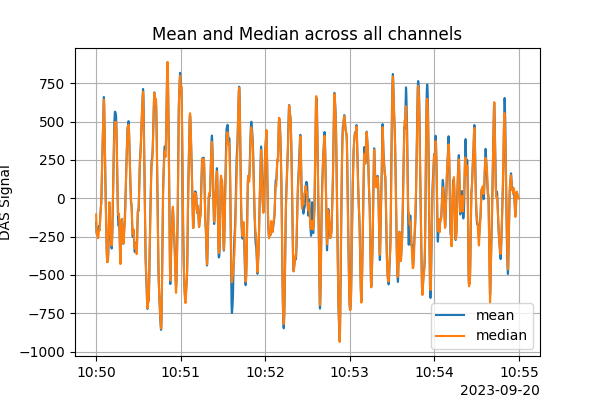

In [32]:
# TODO move this to utils or part of preprocessing
if analysis_opt["allchandt"] is True:
    # Calculate the all-channel trends using median and mean
    ac_median = np.median(das_data_slc_pp, axis=1) # one value per time step(s)
    ac_mean = np.mean(das_data_slc_pp, axis=1) # one value per time step(s)

#Toggle to plot all-channel trends
do_plot_allchan_trends = True
# do_plot_allchan_trends = False

if (do_plot_allchan_trends) & (analysis_opt["allchandt"]) is True:
    fig_ac_trend, ax_ac_trend = plt.subplots(1, 1, figsize=(6, 4))
    ax_ac_trend.plot(tata_dt64_slc, ac_mean, label="mean")
    ax_ac_trend.plot(tata_dt64_slc, ac_median, label="median")
    ax_ac_trend.legend()
    ax_ac_trend.grid()
    _ = ax_ac_trend.set_title("Mean and Median across all channels")
    _ = ax_ac_trend.set_ylabel("DAS Strain" if analysis_opt["das2eps"] is True else "DAS Signal")

    _format_time_axis_mine(ax_ac_trend, "x")


In [33]:
# Remove the calculated "trend" from the dataset
if analysis_opt["allchandt"] is True:
    das_data_slc_pp_o = das_data_slc_pp
    das_data_slc_pp = das_data_slc_pp - ac_median[:, np.newaxis]
else:
    das_data_slc_pp_o = das_data_slc_pp

#### Optionally, save the preprocessed data for quick analysis

In [ ]:
# # do_save_preproc_data = True
# do_save_preproc_data = False

# # TODO restart from here- also save the analysis_opt as pickle
# if do_save_preproc_data is True:
#     path2dassavez = Path(f"data/das_{"b1_vehcam_pt2_v1"}.npz")
#     if path2dassavez.is_file() is True:
#         print("File already exists, not saving!")
#     else:
#         print(f"Saving file: {path2dassavez}")
#         np.savez_compressed(path2dassavez,
#                             das_data_slc_pp=das_data_slc_pp,
#                             tata_dt64_slc=tata_dt64_slc)

In [40]:
# TODO make this a function?
def timechanslice(lopt, analysis_opt):
    time_slice_idx = (tata_dt64_slc >= np.datetime64(lopt["beg_time"].astimezone(timezone.utc).replace(tzinfo=None))) & (tata_dt64_slc < np.datetime64(lopt["end_time"].astimezone(timezone.utc).replace(tzinfo=None)))
    chan_slice_idx = np.isin(analysis_opt["mmap_chan"], lopt["chans"])
    return np.ix_(time_slice_idx, chan_slice_idx)

# timechan_slice = timechanslice(lopt, analysis_opt)
# print(das_data_slc_pp.shape)
# das_plot = das_data_slc_pp[timechan_slice]
# tata_plot = tata_dt64_slc[timechan_slice[0]]

## DAS data plotting

#### Define patch

In [41]:
attrs = dict(
    category="DAS",
    id="near_bridges",
    data_units="das",
)

# For mmap slices
wf_chan = analysis_opt["mmap_chan"]
wf_time = tata_dt64_slc

wf_coords = dict(CH=wf_chan, Time=wf_time)

wf_patch = dc.Patch(
    data=das_data_slc_pp.T,
    # data=das_data_slc_pp_chdt.T, # TODO temp. var. name
    coords=wf_coords, dims=('CH', 'Time'))


#### Waterfall plot visualizations options

In [42]:
print(np.percentile(np.abs(wf_patch.data), 99))
print(np.percentile(np.abs(wf_patch.data), 97))
print(np.percentile(np.abs(wf_patch.data), 95))

5876.959792008359
2363.8562907294354
1408.0060437432587


#### Plot clipping option
- Dataset and location dependent- 99% for mapping/quasi-static
- Usually values within 95 ~ 99.5% will yield good results

In [43]:
# pclip = 95
# pclip = 97
pclip = 99.7
# pclip = 98.5
# pclip = 99
# pclip = 99.5
# pclip = 99.8
pclip = 99.5
vmax = np.percentile(np.abs(wf_patch.data), pclip)
vmin = -vmax
print(f"vmax: {vmax}, vmin: {vmin}")
# test_patch.viz.waterfall(show=True, log=False, cmap="seismic", ax=ax_wf, vmax=vmax, vmin=vmin)

vmax: 9770.684473386285, vmin: -9770.684473386285


In [44]:
# Dict of the list of tap test channels in "CH" and the time of vehicle crossing (closest) in "Time"
print(vehicle_tap_crossings_all)

[{'CH': 254, 'Time': Timestamp('2023-09-27 11:54:07.799962386+0000', tz='UTC')}, {'CH': 669, 'Time': Timestamp('2023-09-27 11:54:19.799967709+0000', tz='UTC')}, {'CH': 2427, 'Time': Timestamp('2023-09-27 11:54:19.799967709+0000', tz='UTC')}, {'CH': 3450, 'Time': Timestamp('2023-09-27 11:54:19.799967709+0000', tz='UTC')}, {'CH': 4820, 'Time': Timestamp('2023-09-27 11:14:26.200035810+0000', tz='UTC')}, {'CH': 5410, 'Time': Timestamp('2023-09-27 10:53:38.400004510+0000', tz='UTC')}, {'CH': 6156, 'Time': Timestamp('2023-09-27 10:53:38.199985477+0000', tz='UTC')}, {'CH': 7976, 'Time': Timestamp('2023-09-27 10:50:05.599991978+0000', tz='UTC')}, {'CH': 8465, 'Time': Timestamp('2023-09-27 10:50:05.599991978+0000', tz='UTC')}, {'CH': 9120, 'Time': Timestamp('2023-09-27 10:50:05.599991978+0000', tz='UTC')}, {'CH': 10140, 'Time': Timestamp('2023-09-27 10:50:24.999997392+0000', tz='UTC')}, {'CH': 10672, 'Time': Timestamp('2023-09-27 10:51:07.800046876+0000', tz='UTC')}, {'CH': 11240, 'Time': Times

254 2023-09-27 11:54:07.799962386+00:00
669 2023-09-27 11:54:19.799967709+00:00
2427 2023-09-27 11:54:19.799967709+00:00
3450 2023-09-27 11:54:19.799967709+00:00
4820 2023-09-27 11:14:26.200035810+00:00
5410 2023-09-27 10:53:38.400004510+00:00
6156 2023-09-27 10:53:38.199985477+00:00
7976 2023-09-27 10:50:05.599991978+00:00
8465 2023-09-27 10:50:05.599991978+00:00
9120 2023-09-27 10:50:05.599991978+00:00
10140 2023-09-27 10:50:24.999997392+00:00
10672 2023-09-27 10:51:07.800046876+00:00
11240 2023-09-27 10:51:31.400039571+00:00
12202 2023-09-27 10:52:07.200046557+00:00
13824 2023-09-27 10:52:10.000011253+00:00
14752 2023-09-27 10:52:10.399958788+00:00
15505 2023-09-27 10:52:10.000011253+00:00
17405 2023-09-27 10:52:07.000027524+00:00
18242 2023-09-27 10:52:01.999974178+00:00
18740 2023-09-27 10:51:20.799966303+00:00
19242 2023-09-27 10:51:17.200026063+00:00
19890 2023-09-27 10:51:20.799966303+00:00
20825 2023-09-27 10:51:17.799982574+00:00
22167 2023-09-27 10:51:30.799982473+00:00
2309

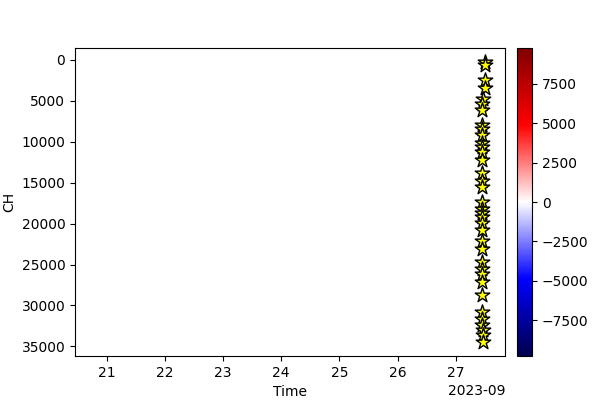

In [46]:
fig_wf, ax_wf = plt.subplots(1, 1, figsize=(6, 4))

ax_wf, selected_points = das_waterfall(patch=wf_patch, dims=('CH', 'Time'),
                      ax=ax_wf, coords=wf_coords,
                      vmax=vmax, vmin=vmin,
                      scale_type="relative",
                      peakpick=True,
                      vehicle_tap_crossings=vehicle_tap_crossings_all
                      )

# plt.show(block=Txrue) # Ensure that the plot is interactive in Jupyter?


Currently plotting from the 
The Correct things- 
- Channel peaks at a given time


In [149]:
selected_points


[(19620.475790577984, 5417.424257884966),
 (19620.47583832434, 5595.911038961033),
 (19620.47590994387, 5695.0703617810705),
 (19620.475981563402, 5814.061549165114),
 (19620.47604522521, 5933.052736549159),
 (19620.476172548817, 6151.203246753241),
 (19620.47624416835, 6250.362569573278),
 (19620.476347618784, 6409.017486085338),
 (19620.476490857844, 6547.84053803339),
 (19620.476602266004, 6627.1679962894195),
 (19620.476642054633, 6765.991048237471),
 (19620.47672163189, 6924.64596474953),
 (19620.47679325142, 7003.97342300556),
 (19620.476817124596, 7122.964610389605),
 (19620.476880786402, 7341.115120593687),
 (19620.476944448208, 7479.938172541739),
 (19620.47703198319, 7598.9293599257835),
 (19620.47708768727, 7658.424953617806),
 (19620.477191137703, 7757.584276437842),
 (19620.477302545863, 7916.239192949902),
 (19620.477398038573, 8154.221567717991),
 (19620.477429869476, 8174.0534322819985),
 (19620.47749353128, 8233.549025974022),
 (19620.477533319907, 8332.708348794058),


## DAS peak-based channel mapping

In [ ]:
# Save the selected points from the above, into a CSV file
manual_knots = np.array(selected_points)
np.savetxt("mapping_stretch_1_manually_picked_points_09_27_2023.csv", manual_knots)
# np.savetxt("b1_cam_based_passes_mansel.csv", manual_knots)

# Or, load the previously saved points into memory
# manual_knots = np.loadtxt("results/mapping_cw_1_manually_picked_points.csv") # load manually picked peaks
# manual_knots = np.loadtxt("results/mapping_cw_1_manually_picked_points_bridge2.csv") # load manually picked peaks
# manual_knots = np.loadtxt("results/mapping_cw_1_manually_picked_points_try2.csv") # load manually picked peaks
# manual_knots = np.loadtxt("results/mapping_cw_2_10-02_manually_picked_points_try1.csv") # load manually picked peaks
# manual_knots = np.loadtxt("results/mapping_cw_2_10-02_manually_picked_points_try2.csv") # load manually picked peaks
manual_knots = np.loadtxt("mapping_stretch_1_manually_picked_points_09_27_2023.csv") # with new channel ranges, for use with interpolation
# manual_knots = np.loadtxt("b1_cam_based_passes_mansel.csv") # manually selected

In [ ]:
manual_knots = np.loadtxt("mapping_stretch_1_manually_picked_points_09_27_2023.csv")

In [43]:
analysis_opt["mmap_chan"][0]

5410

In [44]:
# Sort the peaks by ascending time
man_knots_sorted = manual_knots[manual_knots[:, 1].argsort()]

# mp_chan = np.full((man_knots_sorted.shape[0], 1), np.nan)
mp_chan = []
mp_chan_time = []

# Peak finding window TODO make this dynamic?
peak_pick_window = np.timedelta64(2, 's') # 2 seconds- pretty narrow? seems sufficient for now

# First iterate through each manually picked point and find the peaks
for i, (time_i, chan_i_pnt) in enumerate(man_knots_sorted[:, :]):
    # print(f"Point {i}: Time {time_i}, Chan {chan_i_pnt}")

    # Let's find the "real" peak by using the peak_prominence
    # Define window?

    # print(np.floor(chan_i_pnt))
    # print(time_i)

    peak_npdt64 = np.datetime64(mdates.num2date(time_i).replace(tzinfo=None), 'us')

    time_slice = ((wf_time > peak_npdt64 - peak_pick_window) &
         (wf_time < peak_npdt64 + peak_pick_window))
    
    chan_slice = np.round(chan_i_pnt).astype(int) - analysis_opt["mmap_chan"][0]
    # print(i, time_i, time_slice, chan_i_pnt, chan_slice)
    # find the peak in the window
    das_data_peak_finding = das_data_slc_pp[time_slice, chan_slice]
    das_data_peak_finding = das_data_peak_finding/np.nanmax(np.abs(das_data_peak_finding))
    # das_data_peak_finding = np.abs(das_data_peak_finding) # maybe use this? Nvm...
    tata_pf = tata_dt64_slc[time_slice]

    peaks, properties = signal.find_peaks(das_data_peak_finding, prominence=1.0)  # Adjust prominence value as needed

    # Extract peak prominences
    prominences = properties['prominences']

    if len(peaks) == 0:
        print(f"No peak found at {i}")
        # TODO handle when there are no peaks

        # Skip for now- removing the manually picked peaks!!!
        # mp_chan_time.append(np.nan)
        # mp_chan[i, 0] = np.round(chan_i_pnt).astype(int)

        continue

        # peaks, properties = signal.find_peaks(das_data_peak_finding, prominence=0.5)  # Adjust prominence value as needed
        # peaks = np.array(np.argmax(np.abs(das_data_peak_finding[peaks])))
        # print(peaks)
        # if len(peaks) == 0:
        #     print(f"No peak found at {i} even after lowering prominence")
        #     # TODO handle when there are no peaks
        #     peaks = np.array([np.argmax(das_data_peak_finding)])

    if len(peaks) > 1:
        print(f"More than 1 peak at {i}")
        # TODO handle when there are multiple peaks
        peaks = np.array([peaks[np.argmax(das_data_peak_finding[peaks])]])

    # TODO check peak-finding method
    # TODO make the peak-finding method a function since it's used repeatedly
    # plot_peak_finding = False
    # # plot_peak_finding = True
    # if plot_peak_finding is True:
    #     plt.close("all")
    #     fig_fpp, ax_fpp = plt.subplots(1, 1, figsize=(4, 3))
    #     # ax_fpp.plot(tata_pf, das_data_peak_finding)
    #     # ax_fpp.plot(tata_pf, prominences)

    #     ax_fpp.plot(das_data_peak_finding, label='DAS Data')
    #     ax_fpp.plot(peaks, das_data_peak_finding[peaks], "x", label='Peaks')
    #     ax_fpp.vlines(x=peaks, ymin=das_data_peak_finding[peaks] - prominences, ymax=das_data_peak_finding[peaks], color='C1')

    mp_chan_time.append(tata_pf[peaks[0]])
    mp_chan.append(np.round(chan_i_pnt).astype(int))
    # mp_chan[i, 0] = np.round(chan_i_pnt).astype(int)


No peak found at 0
No peak found at 2
No peak found at 5
No peak found at 6
No peak found at 7
No peak found at 8
No peak found at 9
No peak found at 10
No peak found at 11
No peak found at 14
No peak found at 15
No peak found at 16
No peak found at 17
No peak found at 18
No peak found at 20
No peak found at 21
No peak found at 23
No peak found at 25
No peak found at 27
No peak found at 28
No peak found at 29
No peak found at 33
No peak found at 36
No peak found at 38
No peak found at 39
No peak found at 40
No peak found at 42
No peak found at 44
No peak found at 46


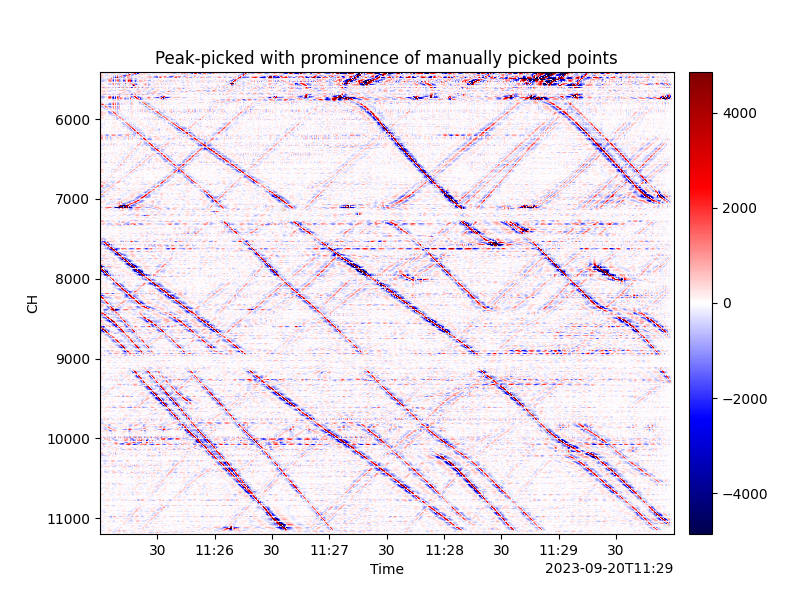

In [45]:
# Plot again with the manually picked points that have been auto peak picked
fig_wf, ax_wf = plt.subplots(1, 1, figsize=(8, 6))
ax_wf.set_title("Peak-picked with prominence of manually picked points")

ax_wf, selected_points = das_waterfall(patch=wf_patch, dims=('CH', 'Time'),
                      ax=ax_wf, coords=wf_coords,
                      vmax=vmax, vmin=vmin,
                      scale_type="relative",
                      preselected_points=[{'CH': mp_chan, 'Time': mp_chan_time}],
                      # preselected_points={'chan': man_knots_sorted[:, 1], 'time': man_knots_sorted[:, 0]},
                      )

In [46]:
# Second, iterate through each "box" of the channels and find the peak for all the channels
# If the found peaks are not smoothly increasing, just interpolate using the boundaries of the boxes

# mp_chan_time_unix = (mp_chan_time - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 'us')
mp_chan_time_unix = (mp_chan_time - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 'us')
# Third, when we have the "peak" location for each channel,
# query the closest time on the GPS of the car, and use that as location of the channel

mpex_chan = []
mpex_chan_time = []

peak_pick_window = np.timedelta64(2, 's')

for i, mp_chan_i in enumerate(mp_chan[:-1]): # except for last one
    # Create linear interpolation, for now, between the "boxes"
    interp_func = interp1d(
        [mp_chan[i], mp_chan[i+1]],
        [mp_chan_time_unix[i], mp_chan_time_unix[i+1]],
        kind="linear",
        fill_value="extrapolate"
    )

    # Interpolate between the two points for all channels in between, end exclusive
    y_interped = interp_func(np.arange(mp_chan[i], mp_chan[i+1]))
    y_interped_dt64 = np.datetime64('1970-01-01T00:00:00') + np.timedelta64(1, 'us')*y_interped

    block_i_chans = np.arange(mp_chan[i], mp_chan[i+1])

    for i, chan_i in enumerate(block_i_chans):
        time_slice = ((wf_time > y_interped_dt64[i] - peak_pick_window) &
            (wf_time < y_interped_dt64[i] + peak_pick_window))

        # DAS data to use for peak-picking
        das_data_peak_finding = das_data_slc_pp[time_slice, chan_i - analysis_opt["mmap_chan"][0]]
        das_data_peak_finding = das_data_peak_finding/np.nanmax(np.abs(das_data_peak_finding))

        # Time data in the peak-picking
        tata_pf = tata_dt64_slc[time_slice]

        peaks, properties = signal.find_peaks(das_data_peak_finding, prominence=1.0)  # Adjust prominence value as needed

        prominences = properties['prominences']

        if len(peaks) == 0:
            # print(f"No peak found at {i}")
            # TODO handle when there are no peaks
            # Just use the interpolated values
            mpex_chan.append(chan_i)
            mpex_chan_time.append(y_interped_dt64[i])
            continue

        if len(peaks) > 1:
            # print(f"More than 1 peak at {i}")
            # TODO handle when there are multiple peaks
            peaks = np.array([peaks[np.argmax(das_data_peak_finding[peaks])]])

        mpex_chan.append(chan_i)
        mpex_chan_time.append(tata_pf[peaks[0]])

    # Add the manually picked points and interpolated points to the new list
    # mpex_chan.append(np.arange(mp_chan[i], mp_chan[i+1]))
    # mpex_chan_time_unix.append(y_interped.reshape(-1, 1))

    # Starting from mp_chan_i to the next mp_chan_i,
    # First create an interpolation or regression line between the two points
    # here, "x" is the channel number, and "y" is the time (in UNIX time)
    # Then, for each channel in the box, find the intersecting point,
    # Then, for the point and inside a certain window size, find the peak
    # Save the peaks (chans and times) in a list/nparray, and return them

mpex_chan_time_unix = (mpex_chan_time - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 'us')
# mpex_chan_time = np.datetime64('1970-01-01T00:00:00') + np.timedelta64(1, 'us')*mpex_chan_time_unix

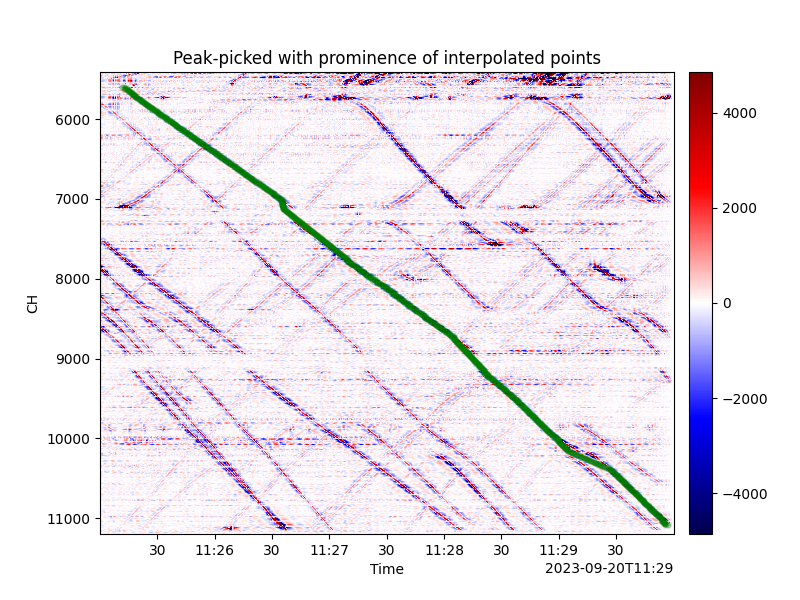

In [47]:
# Plot again with the automatically picked points that have been interpolated
fig_wf, ax_wf = plt.subplots(1, 1, figsize=(8, 6))
ax_wf.set_title("Peak-picked with prominence of interpolated points")
ax_wf, selected_points = das_waterfall(patch=wf_patch, dims=('CH', 'Time'),
                      ax=ax_wf, coords=wf_coords,
                      vmax=vmax, vmin=vmin,
                      scale_type="relative",
                      preselected_points=[{'CH': mpex_chan, 'Time': mpex_chan_time}],
                      # preselected_points={'chan': man_knots_sorted[:, 1], 'time': man_knots_sorted[:, 0]},
                      )

In [48]:
x_data = mpex_chan
y_data = mpex_chan_time_unix
print(x_data)
print(y_data)

[5596, 5597, 5598, 5599, 5600, 5601, 5602, 5603, 5604, 5605, 5606, 5607, 5608, 5609, 5610, 5611, 5612, 5613, 5614, 5615, 5616, 5617, 5618, 5619, 5620, 5621, 5622, 5623, 5624, 5625, 5626, 5627, 5628, 5629, 5630, 5631, 5632, 5633, 5634, 5635, 5636, 5637, 5638, 5639, 5640, 5641, 5642, 5643, 5644, 5645, 5646, 5647, 5648, 5649, 5650, 5651, 5652, 5653, 5654, 5655, 5656, 5657, 5658, 5659, 5660, 5661, 5662, 5663, 5664, 5665, 5666, 5667, 5668, 5669, 5670, 5671, 5672, 5673, 5674, 5675, 5676, 5677, 5678, 5679, 5680, 5681, 5682, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 5690, 5691, 5692, 5693, 5694, 5695, 5696, 5697, 5698, 5699, 5700, 5701, 5702, 5703, 5704, 5705, 5706, 5707, 5708, 5709, 5710, 5711, 5712, 5713, 5714, 5715, 5716, 5717, 5718, 5719, 5720, 5721, 5722, 5723, 5724, 5725, 5726, 5727, 5728, 5729, 5730, 5731, 5732, 5733, 5734, 5735, 5736, 5737, 5738, 5739, 5740, 5741, 5742, 5743, 5744, 5745, 5746, 5747, 5748, 5749, 5750, 5751, 5752, 5753, 5754, 5755, 5756, 5757, 5758, 5759, 5760, 5761, 576

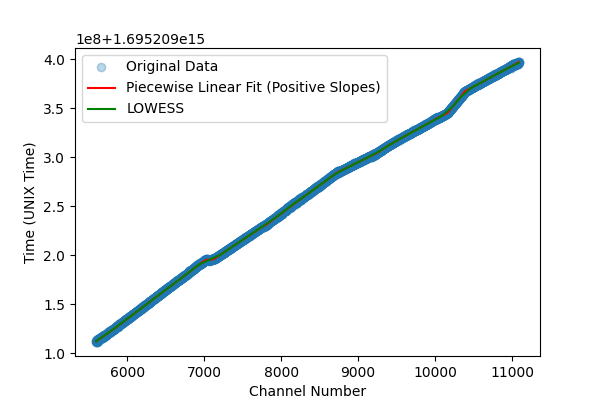

In [49]:
def enforce_positive_slopes(x, y, max_breakpoints=10, max_iter=100):
    """
    Perform piecewise linear regression with automatic breakpoint detection
    and enforce that all slopes are positive.

    Parameters:
    - x: The independent variable (e.g., channel range).
    - y: The dependent variable (e.g., some measured values).
    - max_breakpoints: The maximum number of breakpoints to try.
    - max_iter: Maximum iterations to refine and adjust breakpoints.

    Returns:
    - y_hat: The predicted y values from the positive-slope piecewise fit.
    - breaks: The breakpoints used in the final model.
    """
    # Initialize the piecewise linear fit model
    my_pwlf = pwlf.PiecewiseLinFit(x, y)

    # Perform an initial fit, up to max_breakpoints
    breaks = my_pwlf.fitfast(maxiter=max_iter, n_segments=max_breakpoints)

    # Get the initial slopes
    slopes = np.diff(my_pwlf.predict(np.array(breaks)))

    iter_count = 0
    while np.any(slopes < 0) and iter_count < max_iter:
        iter_count += 1
        # If negative slopes exist, remove the segment with the most negative slope
        # Find the segment with the most negative slope
        negative_slope_index = np.argmin(slopes)

        # Remove the breakpoint associated with the negative slope
        if negative_slope_index + 1 < len(breaks):
            # TODO check if this is okay to be remvoved
            # del_breakpoint = breaks[negative_slope_index + 1]
            breaks = np.delete(breaks, negative_slope_index + 1)

        # Re-fit the piecewise linear model with the modified breakpoints
        my_pwlf.fit_with_breaks(breaks)

        # Recalculate the slopes
        slopes = np.diff(my_pwlf.predict(np.array(breaks)))

    # After the loop, we should have positive slopes
    y_hat = my_pwlf.predict(x)

    return y_hat, breaks

# Example usage
# x = x_data
# y = y_data

# Run the positive slope piecewise linear regression
y_hat, final_breaks = enforce_positive_slopes(x_data, y_data, max_breakpoints=20)

# LOWESS smoothing
# lowess_fit = lowess(y_data, x_data, frac=0.03) # 0.03 seems pretty good- how to determine this automatically?
# lowess_fit = lowess(y_data, x_data, frac=0.08) # 0.08 makes a much smoother curve
lowess_fit = lowess(y_data, x_data, frac=0.05) # 0.03 seems pretty good- how to determine this automatically?
# lowess_fit = lowess(y_data, x_data, frac=0.04) # 0.03 seems pretty good- how to determine this automatically?
# lowess_fit = lowess(y_data, x_data, frac=0.03) # 0.03 seems pretty good- how to determine this automatically?
# lowess_fit = lowess(y_data, x_data, frac=0.02) # 0.03 seems pretty good- how to determine this automatically?
x_lowess = lowess_fit[:, 0]
y_lowess = lowess_fit[:, 1]

# Plot the results
fig_smt, ax_smt = plt.subplots(1, 1, figsize=(6, 4))
ax_smt.plot(x_data, y_data, 'o', label='Original Data', alpha=0.3)
ax_smt.plot(x_data, y_hat, '-', label='Piecewise Linear Fit (Positive Slopes)', color='red')
ax_smt.plot(x_data, y_lowess, '-', label='LOWESS', color='green')
ax_smt.set_xlabel('Channel Number')
ax_smt.set_ylabel('Time (UNIX Time)')
ax_smt.legend()

In [50]:
# Convert datetime
y_lowess_npdt64 = np.datetime64('1970-01-01T00:00:00') + np.timedelta64(1, 'us')*y_lowess

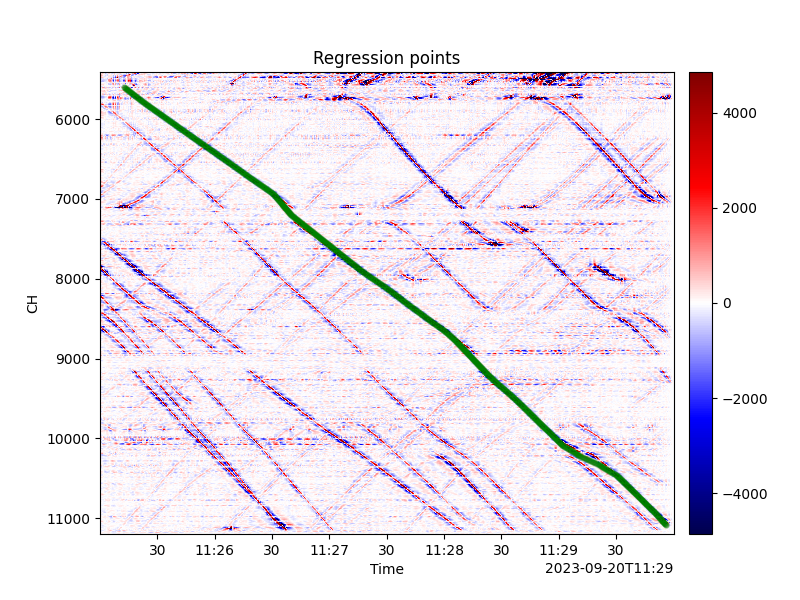

In [51]:
fig_wf, ax_wf = plt.subplots(1, 1, figsize=(8, 6))
ax_wf.set_title("Regression points")
ax_wf, selected_points = das_waterfall(patch=wf_patch, dims=('CH', 'Time'),
                      ax=ax_wf, coords=wf_coords,
                      vmax=vmax, vmin=vmin,
                      scale_type="relative",
                      preselected_points=[{'CH': x_lowess, 'Time': y_lowess_npdt64}],
                      # preselected_points={'chan': man_knots_sorted[:, 1], 'time': man_knots_sorted[:, 0]},
                      )

In [ ]:
# mp_gps_df = pd.read_parquet(Path("results/mapping_cw_run1_COM3_20230927_031243.parquet"))
# mp_gps_df = pd.read_parquet(Path("G:\\Shared drives\\SJC Experiment\\fiber_mapping\\mapping_code\\mapping_ccw_run_10-02_COM8_20231002_025202.parquet"))
# mp_gps_df = mp_gps_df.dropna(subset=["npdt64"])
# mp_gps_df_dts = mp_gps_df["npdt64"].values # np dt64 of the GPS data

In [52]:
# Ensure y_lowess_npdt64 is in datetime64[ns, UTC] for comparison
y_times = pd.to_datetime(y_lowess_npdt64).tz_localize('UTC')
# y_times = channel_time_excel_df["das_time_extrapolated"].values
# das_lag = - np.timedelta64(2100, "ms")
das_lag = - np.timedelta64(0, "ms")
# y_times = y_times - das_lag  # It was adjusted for DAS lag, need to revert back # done once
# x_lowess = channel_time_excel_df["chan"].values
# Get the vehicle timestamps as numpy array for fast search
vehicle_times = vehicle_df['datetime_utc'].values

In [53]:
print(y_times[:5])
print(x_lowess[:5])

DatetimeIndex(['2023-09-20 11:25:12.406651+00:00',
               '2023-09-20 11:25:12.460316+00:00',
               '2023-09-20 11:25:12.513281+00:00',
               '2023-09-20 11:25:12.567037+00:00',
               '2023-09-20 11:25:12.620260+00:00'],
              dtype='datetime64[us, UTC]', freq=None)
[5596. 5597. 5598. 5599. 5600.]


In [54]:
# ####Run these just once
# y_times = pd.to_datetime(y_times).tz_localize('UTC')
vehicle_times = pd.to_datetime(vehicle_times).tz_localize('UTC')  # Ensure it's in UTC

In [55]:
print("vehicle_times dtype:", vehicle_times.dtype)
print("y_times dtype:", y_times.dtype)
print("First vehicle_times value:", vehicle_times[0])
print("First y_times value:", y_times[0])

vehicle_times dtype: datetime64[ns, UTC]
y_times dtype: datetime64[us, UTC]
First vehicle_times value: 2023-09-20 11:17:23.799987810+00:00
First y_times value: 2023-09-20 11:25:12.406651+00:00


In [59]:
two_closest_vehicle_rows = get_two_closest_rows_naive(y_times, vehicle_times, vehicle_df)
print(two_closest_vehicle_rows[0]["datetime_utc"]) 
print(two_closest_vehicle_rows[100]["datetime_utc"]) 

0   2023-09-20 11:25:12.399970736+00:00
1   2023-09-20 11:25:12.599989769+00:00
Name: datetime_utc, dtype: datetime64[ns, UTC]
0   2023-09-20 11:25:17.799971626+00:00
1   2023-09-20 11:25:17.600043115+00:00
Name: datetime_utc, dtype: datetime64[ns, UTC]


In [60]:
mp_chan_to_gps_data = get_the_gps_for_channels(y_times, x_lowess, two_closest_vehicle_rows)
mp_chan_to_gps_data.head()
# Create dataframe of
df_lclz = pd.DataFrame({
    "chan": mp_chan_to_gps_data["Channel"],
    # "Latitude": mp_gps_df["Latitude"].iloc[closest_indices].values,
    # "Longitude": mp_gps_df["Longitude"].iloc[closest_indices].values,
    "Latitude": mp_chan_to_gps_data["Lat"],
    "Longitude": mp_chan_to_gps_data["Lon"],
    "das_time_extrapolated": mp_chan_to_gps_data["Time"],
    # "das_time_extrapolated": y_lowess_npdt64_corrected,
    # "gps_time": mp_gps_df["npdt64"].iloc[closest_indices].values,
    # "siyuan_lat": sy_lclz["lat"].iloc[found_indices].values,
    # "siyuan_lon": sy_lclz["long"].iloc[found_indices].values,
})

df_lclz.head()

chan   Latitude   Longitude      das_time_extrapolated
0  5596.0  37.304527 -121.862231 2023-09-20 11:25:12.406651
1  5597.0  37.304521 -121.862225 2023-09-20 11:25:12.460316
2  5598.0  37.304515 -121.862219 2023-09-20 11:25:12.513281
3  5599.0  37.304509 -121.862213 2023-09-20 11:25:12.567037
4  5600.0  37.304503 -121.862207 2023-09-20 11:25:12.620260

In [ ]:
df_lclz.to_excel("mapping_results_localization_stretch_1_09-27-23.xlsx", index=False)

In [ ]:
# mp_gps_df_dts = vehicle_df['datetime_utc'].values

In [ ]:
# def find_closest_elements(A, B):
#     # Reshape A to be a column vector (N, 1) and subtract B, which is a row vector (M,)
#     # This creates a difference matrix of shape (N, M)
#     # We use broadcasting here for efficiency
#     diffs = np.abs(A[:, np.newaxis] - B)

#     # Find the index of the minimum difference for each element in A
#     closest_indices = np.argmin(diffs, axis=1)

#     # Retrieve the closest elements in B
#     closest_elements = B[closest_indices]

#     return closest_indices, closest_elements

# def find_two_closest_elements(A, B):
#     # Calculate the absolute differences between A and B
#     diffs = np.abs(A[:, np.newaxis] - B)

#     # Find the indices of the two smallest differences for each element in A
#     closest_indices = np.argpartition(diffs, 2, axis=1)[:, :2]

#     # Sort the two closest indices for each element in A
#     closest_indices = np.sort(closest_indices, axis=1)

#     # Retrieve the two closest elements from B
#     closest_elements = B[closest_indices]

#     return closest_indices, closest_elements

In [ ]:
# # DAS files are already in UTC- no need to convert
# closest_indices, closest_elements = find_closest_elements(y_lowess_npdt64, mp_gps_df_dts)

In [ ]:
# # two_closest_indices, two_closest_elements = find_two_closest_elements(y_lowess_npdt64, mp_gps_df_dts)
# # TODO manually corrected version of the DAS time, shifted by 2.1 seconds

# das_lag = - np.timedelta64(2100, "ms")
# y_lowess_npdt64_corrected = y_lowess_npdt64 + das_lag

# two_closest_indices, two_closest_elements = find_two_closest_elements(
#     y_lowess_npdt64_corrected, mp_gps_df_dts)


In [ ]:
# def interpolate_gps_np(datetime1, datetime2, gps1, gps2, target_datetime):
#     # Ensure inputs are numpy datetime64 objects
#     datetime1 = np.datetime64(datetime1)
#     datetime2 = np.datetime64(datetime2)
#     target_datetime = np.datetime64(target_datetime)

#     # Calculate the time differences in seconds (use timedelta64 for time calculations)
#     total_time = (datetime2 - datetime1) / np.timedelta64(1, 's')  # Total duration in seconds
#     elapsed_time = (target_datetime - datetime1) / np.timedelta64(1, 's')  # Elapsed time in seconds

#     # Calculate the time fraction for interpolation
#     time_fraction = elapsed_time / total_time

#     # Linearly interpolate the GPS coordinates
#     interpolated_latitude = gps1[0] + time_fraction * (gps2[0] - gps1[0])
#     interpolated_longitude = gps1[1] + time_fraction * (gps2[1] - gps1[1])

#     return interpolated_latitude, interpolated_longitude

In [ ]:
# interped_gps_lat = np.full((y_lowess_npdt64_corrected.shape[0], 1), np.nan)
# interped_gps_lon = np.full((y_lowess_npdt64_corrected.shape[0], 1), np.nan)

In [ ]:
# # TODO maybe interpolate the closest elements and print out their
# # GPS coordinates- better than just the closest point probably

# for i, (idx, elem) in enumerate(zip(two_closest_indices, two_closest_elements)):
#     # print(f"Interpolate this: {y_lowess_npdt64[i]}")
#     # print(f"Between {elem} at index {idx}")

#     interped_gps_lat_i, interped_gps_lon_i = interpolate_gps_np(datetime1=elem[0], datetime2=elem[1],
#                        gps1=[mp_gps_df["Latitude"].iloc[idx[0]], mp_gps_df["Longitude"].iloc[idx[0]]],
#                        gps2=[mp_gps_df["Latitude"].iloc[idx[1]], mp_gps_df["Longitude"].iloc[idx[1]]],
#                        target_datetime=y_lowess_npdt64[i])

#     interped_gps_lat[i] = interped_gps_lat_i
#     interped_gps_lon[i] = interped_gps_lon_i



In [ ]:
# sy_lclz = pd.read_csv("siyuan_channel_location.csv", index_col=0)
# found_indices = np.where(np.isin(sy_lclz["Channels"].values, mpex_chan))[0]


In [ ]:
# Create dataframe of
df_lclz = pd.DataFrame({
    "chan": mpex_chan,
    # "Latitude": mp_gps_df["Latitude"].iloc[closest_indices].values,
    # "Longitude": mp_gps_df["Longitude"].iloc[closest_indices].values,
    "Latitude": interped_gps_lat.flatten(),
    "Longitude": interped_gps_lon.flatten(),
    "das_time_extrapolated": y_lowess_npdt64_corrected,
    # "gps_time": mp_gps_df["npdt64"].iloc[closest_indices].values,
    # "siyuan_lat": sy_lclz["lat"].iloc[found_indices].values,
    # "siyuan_lon": sy_lclz["long"].iloc[found_indices].values,
})



#### Save localization results to a parquet file

In [ ]:
df_lclz

In [ ]:
df_lclz.to_excel("mapping_results_localization.xlsx", index=False)

In [ ]:
import folium

# Plot the GPS points from df_lclz on a folium map with channel numbers as labels


# Calculate the center of the map
center_lat = df_lclz["Latitude"].mean()
center_lon = df_lclz["Longitude"].mean()

gps_map = folium.Map(location=[center_lat, center_lon], zoom_start=13)

for _, row in df_lclz.iterrows():
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=f"Channel: {row['chan']}"
    ).add_to(gps_map)

gps_map

In [ ]:
# df_lclz.to_parquet("mapping_cw_run1_COM3_20230927_031243_lclz_try2.parquet")
# df_lclz.to_parquet("mapping_cw_run1_COM3_20230927_031243_lclz_try3.parquet") # used interpolation between two closest points
# df_lclz.to_parquet("mapping_ccw_run_10-02_COM8_20231002_02520_lclz_try1.parquet")
# df_lclz.to_parquet("mapping_ccw_run_10-02_COM8_20231002_02520_lclz_try2.parquet")
# df_lclz.to_parquet("mapping_ccw_run_10-02_COM8_20231002_02520_lclz_try3.parquet")
# df_lclz.to_parquet("mapping_ccw_run_10-02_COM8_20231002_02520_lclz_try3_lws05.parquet")
# df_lclz.to_parquet("mapping_ccw_run_10-02_COM8_20231002_02520_lclz_try3_lws05_daslag_2100ms.parquet")
# df_lclz.to_parquet("mapping_ccw_run_10-02_COM8_20231002_02520_lclz_try3_lws05_daslag_m2100ms.parquet")

In [ ]:
# # Example usage
# lat_str = "37°21'13.80\"N"
# lon_str = "121°51'59.09\"W"

# latitude = dms_to_decimal(lat_str)
# longitude = dms_to_decimal(lon_str)

# print(f"Latitude: {latitude}")
# print(f"Longitude: {longitude}")


In [ ]:
df_lclz = pd.read_parquet(Path("G:\\Shared drives\\SJC Experiment\\fiber_mapping\\mapping_code\\mapping_ccw_run_10-02_COM8_20231002_02520_lclz_try3_lws05.parquet"))
# df_lclz = pd.read_parquet("mapping_ccw_run_10-02_COM8_20231002_02520_lclz_try3_lws05_daslag_2100ms.parquet")
# df_lclz = pd.read_parquet("mapping_ccw_run_10-02_COM8_20231002_02520_lclz_try3_lws05_daslag_m2100ms.parquet")


In [ ]:
# Create a list of dictionaries
# TODO update bridge points to be dict, check influence line code for implementation

bridge_points = [
    # {"name": "Bridge 2 Origin", "lat_dms": "37°21'13.80\"N", "lon_dms": "121°51'59.09\"W"},
    # {"name": "Bridge 2 End", "lat_dms": "37°21'15.95\"N", "lon_dms": "121°51'57.00\"W"},
    # {"name": "Bridge 3 Origin", "lat_dms": "37°21'0.33\"N", "lon_dms": "121°52'25.41\"W"},
    # {"name": "Bridge 3 End", "lat_dms": "37°21'1.06\"N", "lon_dms": "121°52'23.72\"W"},
    {"name": "Bridge 1 Origin", "lat_dms": "37°17'23.31\"N", "lon_dms": "121°49'8.08\"W"},
    {"name": "Bridge 1 End", "lat_dms": "37°17'25.26\"N", "lon_dms": "121°49'4.79\"W"},
    {"name": "Bridge 1 Bound 1", "lat_dms": "37°17'23.05\"N", "lon_dms": "121°49'8.93\"W"},
    {"name": "Bridge 1 Bound 2", "lat_dms": "37°17'25.82\"N", "lon_dms": "121°49'4.13\"W"},
    {"name": "Bridge 1 Span 2 Midspan", "lat_dms": "37°17'24.45\"N", "lon_dms": "121°49'6.45\"W"},
]

for bp_i in bridge_points:
    bp_i["Latitude"] = dms_to_decimal(bp_i["lat_dms"])
    bp_i["Longitude"] = dms_to_decimal(bp_i["lon_dms"])

In [ ]:
bss_gps = pd.read_excel(Path("G:\\Shared drives\\SJC Experiment\\fiber_mapping\\mapping_code\\b1_bss_gps_locations.xlsx"))

In [ ]:
def create_folium_gps_map(gps_df, pdf_pts=None, bss_pts=None):

    # calculate center
    center_lat = gps_df['Latitude'].mean()
    center_lon = gps_df['Longitude'].mean()


    city_map = folium.Map(location=[center_lat, center_lon], zoom_start=12, max_zoom=24)

    if pdf_pts is None:
        pass
    else:
        # TODO add boundary based on satellite image
        for pti in pdf_pts:
            folium.Marker(
                location=[pti["Latitude"], pti["Longitude"]],
                popup=pti["name"]
            ).add_to(city_map)

    if bss_pts is None:
        pass
    else:
        for bssi in bss_pts.iterrows():
            folium.Marker(
                location=[bssi[1]["Latitude"], bssi[1]["Longitude"]],
                popup=bssi[1]["Name"]
            ).add_to(city_map)
    # b2_beg = ["37°21'13.80N", "121°51'59.09W"]
    # b2_end = []

    # folium.CircleMarker(
    #         location=[row['Latitude'], row['Longitude']],
    #         # radius=3,  # smaller circle
    #         radius=1,  # smaller circle
    #         color='purple',
    #         fill=True,
    #         fill_color='purple',
    #         fill_opacity=0.6,
    #         popup=f"SJC Lclz.: {row['chan']}"
    #     ).add_to(city_map)

    # make a PolyLine to represent the driving path
    # path = folium.PolyLine(
    #     locations=gps_df[['Latitude','Longitude']].values,
    #     color='blue',
    #     weight=5,
    #     opacity=0.7
    # )
    # path.add_to(city_map)

    # Add markers with timestamps
    # TODO why every 4 channels?
    for index, row in gps_df[::].iterrows():
        # print(row["chan"])
        # folium.Marker(
        #     location=[row['Latitude'], row['Longitude']],
        #     popup=row["chan"]
        #     # popup=f"Time: {row['npdt64'].to_datetime64()}"
        # ).add_to(city_map)

        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            # radius=3,  # smaller circle
            radius=1,  # smaller circle
            color='purple',
            fill=True,
            fill_color='purple',
            fill_opacity=0.6,
            popup=f"SJC Lclz.: {row['chan']}"
        ).add_to(city_map)

        # folium.CircleMarker(
        #     location=[row['siyuan_lat'], row['siyuan_lon']],
        #     radius=3,  # smaller circle
        #     color='red',
        #     fill=True,
        #     fill_color='red',
        #     fill_opacity=0.6,
        #     popup=f"SY Lclz.: {row['chan']}"
        # ).add_to(city_map)


    return city_map

In [ ]:
mapping_res_map = create_folium_gps_map(
    df_lclz, pdf_pts=bridge_points, bss_pts=bss_gps)
mapping_res_map
# 26603 based on the positive 2.1 s lag
# 26604 based on the negative 2.1 s lag ????
# why no difference?

In [ ]:
# can also save the above map in an html file